# Task 3 — Hypothesis Testing

**ACIS Insurance Risk Analytics**

This notebook performs the hypothesis testing required for Task 3. It:

- Loads the cleaned dataset
- Builds features (HasClaim, Severity, Margin, LossRatio)
- Produces pivot tables & summaries
- Runs hypothesis tests for provinces, postal codes, and gender
- Creates visualizations
- Saves a summary CSV to `reports/` and figures to `visuals/`

> **Usage**: place your cleaned CSV at `data/clean/insurance_claims_cleaned.csv` and run all cells.


In [5]:
# Setup: imports and configuration
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.proportion as smp
from statsmodels.stats.multitest import multipletests
import math, os, json

sns.set(style='whitegrid', context='notebook')

# Paths
ROOT = Path.cwd().parent

DATA_CLEAN = ROOT / 'data' / 'clean' / 'insurance_claims_cleaned.csv'
REPORTS_DIR = ROOT / 'reports'
VISUALS_DIR = ROOT / 'visuals'

REPORTS_DIR.mkdir(parents=True, exist_ok=True)
VISUALS_DIR.mkdir(parents=True, exist_ok=True)

print('ROOT ->', ROOT)
print('DATA_CLEAN ->', DATA_CLEAN)
print('Reports ->', REPORTS_DIR)
print('Visuals ->', VISUALS_DIR)


# Config
MIN_GROUP_N = 30   # minimum group size to include in group-level tests
ALPHA = 0.05

print('DATA_CLEAN ->', DATA_CLEAN)
print('Reports ->', REPORTS_DIR)
print('Visuals ->', VISUALS_DIR)


ROOT -> c:\Users\a_kas\acis-insurance-risk-analytics
DATA_CLEAN -> c:\Users\a_kas\acis-insurance-risk-analytics\data\clean\insurance_claims_cleaned.csv
Reports -> c:\Users\a_kas\acis-insurance-risk-analytics\reports
Visuals -> c:\Users\a_kas\acis-insurance-risk-analytics\visuals
DATA_CLEAN -> c:\Users\a_kas\acis-insurance-risk-analytics\data\clean\insurance_claims_cleaned.csv
Reports -> c:\Users\a_kas\acis-insurance-risk-analytics\reports
Visuals -> c:\Users\a_kas\acis-insurance-risk-analytics\visuals


In [6]:
# Load cleaned data
if not DATA_CLEAN.exists():
    raise FileNotFoundError(f"Clean data file not found at {DATA_CLEAN}.\nPut your cleaned CSV at this path and re-run.")

df = pd.read_csv(DATA_CLEAN)
print('Rows:', len(df))
print('Columns:', df.columns.tolist())
df.head().iloc[:, :12]


Rows: 1000098
Columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio', 'HadClaim', 'ClaimCount', 'ClaimFrequency', 'Severity', 'RiskScore', 'HighRiskFlag', 'ExpensiveVehicleFlag', 'OldVehicleFlag']


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,MaritalStatus,Gender
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified


In [7]:
# Feature engineering: HasClaim, Severity, Margin, LossRatio, normalize some columns
df['TotalClaims'] = pd.to_numeric(df.get('TotalClaims', 0), errors='coerce').fillna(0.0)
df['TotalPremium'] = pd.to_numeric(df.get('TotalPremium', 0), errors='coerce').fillna(0.0)
# HasClaim flag
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
# Margin
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Severity: prefer NumberOfClaims if present
if 'NumberOfClaims' in df.columns:
    df['NumberOfClaims'] = pd.to_numeric(df['NumberOfClaims'], errors='coerce')
    df.loc[df['NumberOfClaims']>0, 'Severity'] = df.loc[df['NumberOfClaims']>0, 'TotalClaims'] / df.loc[df['NumberOfClaims']>0, 'NumberOfClaims']
else:
    df.loc[df['HasClaim']==1, 'Severity'] = df.loc[df['HasClaim']==1, 'TotalClaims']

# LossRatio (per-policy)
df['LossRatio'] = np.where(df['TotalPremium']>0, df['TotalClaims'] / df['TotalPremium'], np.nan)

# Clean PostalCode and Gender
if 'PostalCode' in df.columns:
    df['PostalCode'] = df['PostalCode'].astype(str).fillna('Unknown')

if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].astype(str).str.title().replace({'M':'Male','F':'Female'})

# Ensure PolicyID exists
if 'PolicyID' not in df.columns:
    df['PolicyID'] = df.index.astype(str)

print('Feature columns added: HasClaim, Severity, Margin, LossRatio')
df[['HasClaim','Severity','Margin','LossRatio']].head()


Feature columns added: HasClaim, Severity, Margin, LossRatio


,HasClaim,Severity,Margin,LossRatio
0,0,0.0,21.929825,0.0
1,0,0.0,21.929825,0.0
2,0,0.0,0.000000,NaN
3,0,0.0,512.848070,0.0
4,0,0.0,0.000000,NaN


In [8]:
# Quick summaries
total_policies = df['PolicyID'].nunique()
total_claims = df['HasClaim'].sum()
overall_loss_ratio = df['TotalClaims'].sum() / df['TotalPremium'].sum() if df['TotalPremium'].sum() > 0 else np.nan

print(f'Total policies: {total_policies:,}')
print(f'Policies with claims: {int(total_claims):,} ({total_claims/total_policies:.2%})')
print(f'Overall loss ratio (TotalClaims/TotalPremium): {overall_loss_ratio:.4f}')

# Distribution summaries
display(df[['TotalPremium','TotalClaims','LossRatio','Severity','Margin']].describe().T)


Total policies: 7,000
Policies with claims: 2,788 (39.83%)
Overall loss ratio (TotalClaims/TotalPremium): 1.0477


,count,mean,std,min,25%,50%,75%,max
TotalPremium,1000098.0,61.905496,230.284513,-7.825768e+02,0.0,2.178333,21.929825,65282.603421
TotalClaims,1000098.0,64.861190,2384.074695,-1.200241e+04,0.0,0.000000,0.000000,393092.105263
LossRatio,618176.0,0.350048,9.288639,-1.870012e+01,0.0,0.000000,0.000000,2553.600000
Severity,1000098.0,-inf,NaN,-inf,0.0,0.000000,0.000000,393092.105263
Margin,1000098.0,-2.955694,2367.136547,-3.928486e+05,0.0,2.157687,21.929825,65282.603421


In [9]:
# Cohort summary helper
def cohort_summary(df, group_col):
    g = df.groupby(group_col).agg(
        policies=('PolicyID','nunique'),
        claims=('HasClaim','sum'),
        total_premium=('TotalPremium','sum'),
        total_claims=('TotalClaims','sum'),
        mean_severity=('Severity','mean'),
        mean_margin=('Margin','mean')
    ).reset_index()
    g['claim_freq'] = g['claims'] / g['policies']
    g['loss_ratio'] = np.where(g['total_premium']>0, g['total_claims']/g['total_premium'], np.nan)
    return g

# Province summary
if 'Province' in df.columns:
    prov_summary = cohort_summary(df, 'Province').sort_values('loss_ratio', ascending=False)
    display(prov_summary)
else:
    print('No Province column found')

# Top vehicle types if present
if 'VehicleType' in df.columns:
    vt = cohort_summary(df, 'VehicleType').sort_values('loss_ratio', ascending=False).head(10)
    display(vt)


,Province,policies,claims,total_premium,total_claims,mean_severity,mean_margin,claim_freq,loss_ratio
2,Gauteng,2578,1322,2.405377e+07,2.939415e+07,-inf,-13.558894,0.512801,1.222018
3,KwaZulu-Natal,1370,483,1.320908e+07,1.430138e+07,84.234293,-6.433598,0.352555,1.082693
8,Western Cape,947,370,9.806559e+06,1.038977e+07,-inf,-3.414689,0.390707,1.059472
6,North West,1117,349,7.490508e+06,5.920250e+06,41.317426,10.958832,0.312444,0.790367
5,Mpumalanga,382,128,2.836292e+06,2.044675e+06,-inf,15.016059,0.335079,0.720897
1,Free State,54,11,5.213632e+05,3.549223e+05,43.822975,20.550805,0.203704,0.680758
4,Limpopo,181,67,1.537324e+06,1.016477e+06,40.927553,20.971484,0.370166,0.661199
0,Eastern Cape,319,50,2.140104e+06,1.356427e+06,44.713432,25.833240,0.156740,0.633813
7,Northern Cape,55,8,3.165581e+05,8.949051e+04,14.026726,35.590527,0.145455,0.282699


,VehicleType,policies,claims,total_premium,total_claims,mean_severity,mean_margin,claim_freq,loss_ratio
1,Heavy Commercial,72,21,4.609479e+05,7.504746e+05,101.401781,-39.119946,0.291667,1.628112
3,Medium Commercial,457,158,3.922746e+06,4.119867e+06,76.315030,-3.651410,0.345733,1.050251
4,Passenger Vehicle,6695,2587,5.664202e+07,5.937207e+07,-inf,-2.924228,0.386408,1.048198
5,Unknown,6,13,5.671104e+05,5.566860e+05,1008.489085,18.884893,2.166667,0.981618
2,Light Commercial,39,8,2.604975e+05,6.045250e+04,15.512574,51.333082,0.205128,0.232066
0,Bus,6,1,5.824474e+04,7.996535e+03,12.024865,75.561210,0.166667,0.137292


In [10]:
# Statistical helpers

def chi2_group_freq(df, group_col, min_n=MIN_GROUP_N):
    ct = pd.crosstab(df[group_col], df['HasClaim'])
    ct = ct[ct.sum(axis=1) >= min_n]
    if ct.shape[0] < 2:
        return None
    chi2, p, dof, expected = stats.chi2_contingency(ct.values)
    return {'chi2': chi2, 'p': p, 'dof': dof, 'expected': expected, 'table': ct}

def two_prop_ztest_for_groups(df, group_col, g1, g2):
    a = df[df[group_col]==g1]
    b = df[df[group_col]==g2]
    succ = np.array([a['HasClaim'].sum(), b['HasClaim'].sum()])
    nobs = np.array([len(a), len(b)])
    stat, p = smp.proportions_ztest(count=succ, nobs=nobs, alternative='two-sided')
    return {'z': stat, 'p': p, 'prop1': succ[0]/nobs[0], 'prop2': succ[1]/nobs[1], 'n1': nobs[0], 'n2': nobs[1]}

def numeric_group_test(df, group_col, target_col='Severity', min_n=MIN_GROUP_N):
    df2 = df[df[target_col].notna()]
    groups = [g[target_col].values for _, g in df2.groupby(group_col) if len(g) >= min_n]
    names = [name for name, g in df2.groupby(group_col) if len(g) >= min_n]
    if len(groups) < 2:
        return None
    levene_stat, levene_p = stats.levene(*groups)
    if levene_p > 0.05:
        f, p = stats.f_oneway(*groups)
        method = 'ANOVA'
        stat = f
    else:
        h, p = stats.kruskal(*groups)
        method = 'Kruskal'
        stat = h
    return {'method': method, 'stat': stat, 'p': p, 'levene_p': levene_p, 'groups': names}


In [11]:
# 1) Province: Claim Frequency (Chi-square)
province_result = None
if 'Province' in df.columns:
    province_result = chi2_group_freq(df, 'Province')
    if province_result:
        print('Province chi2:', province_result['chi2'], 'p=', province_result['p'], 'dof=', province_result['dof'])
        display(province_result['table'])
    else:
        print('Not enough Province groups with >=', MIN_GROUP_N)
else:
    print('No Province column available')


Province chi2: 104.19088107029361 p= 5.925510718204678e-19 dof= 8


HasClaim,0,1
Province,,
Eastern Cape,30286,50
Free State,8088,11
Gauteng,392543,1322
KwaZulu-Natal,169298,483
Limpopo,24769,67
Mpumalanga,52590,128
North West,142938,349
Northern Cape,6372,8
Western Cape,170426,370


In [12]:
# 2) Postal Codes: top 30 by count - Claim Frequency (Chi-square)
if 'PostalCode' in df.columns:
    top_postals = df['PostalCode'].value_counts().head(30).index.tolist()
    df_top = df[df['PostalCode'].isin(top_postals)]
    postal_result = chi2_group_freq(df_top, 'PostalCode')
    if postal_result:
        print('Top30 Postal chi2:', postal_result['chi2'], 'p=', postal_result['p'])
        display(postal_result['table'].head(20))
    else:
        print('Not enough postal groups with >=', MIN_GROUP_N)
else:
    print('No PostalCode column found')


Top30 Postal chi2: 139.9001792555519 p= 1.7930769204772686e-16


HasClaim,0,1
PostalCode,,
1022,8460,16
122,48961,210
152,9391,32
1724,10082,25
1863,8611,44
2000,133012,486
2196,11016,32
299,25479,67
302,9510,21


In [13]:
# 3) Province: Claim Severity (ANOVA / Kruskal)
prov_sev = None
if 'Province' in df.columns:
    prov_sev = numeric_group_test(df, 'Province', target_col='Severity', min_n=MIN_GROUP_N)
    if prov_sev:
        print('Province severity test method:', prov_sev['method'], 'stat:', prov_sev['stat'], 'p=', prov_sev['p'])
    else:
        print('Not enough province groups with severity data (min {})'.format(MIN_GROUP_N))
else:
    print('No Province column')


Province severity test method: Kruskal stat: 104.26320929672522 p= 5.726725741368965e-19


In [14]:
# 4) Postal Codes: Margin differences (ANOVA / Kruskal) on top 30 postal codes
postal_margin = None
if 'PostalCode' in df.columns:
    postal_margin = numeric_group_test(df_top, 'PostalCode', target_col='Margin', min_n=MIN_GROUP_N)
    if postal_margin:
        print('Postal margin test method:', postal_margin['method'], 'stat:', postal_margin['stat'], 'p=', postal_margin['p'])
    else:
        print('Not enough postal groups with margin data (min {})'.format(MIN_GROUP_N))
else:
    print('No PostalCode column')


Postal margin test method: Kruskal stat: 12711.01042849163 p= 0.0


In [19]:
# 5) Gender comparisons: Frequency (two-proportion z-test), Severity & Margin (Welch t-tests)
gender_results = {}

if 'Gender' in df.columns:
    gender_counts = df['Gender'].value_counts()
    
    if len(gender_counts) >= 2:
        g1, g2 = gender_counts.index[:2]
        print('Comparing top two gender groups:', g1, 'vs', g2)

        # -------------------- Frequency (two-proportion z-test) --------------------
        res = two_prop_ztest_for_groups(df, 'Gender', g1, g2)
        gender_results['freq'] = res
        print('Frequency z=', res['z'], 'p=', res['p'], 'props:', res['prop1'], res['prop2'])

        # -------------------- Severity (Welch t-test) --------------------
        df_s = df[df['Severity'].notna() & df['Gender'].notna()]

        # Force clean 1-D float arrays
        groups = [
            g['Severity'].astype(float).to_numpy().ravel()
            for _, g in df_s.groupby('Gender')
            if len(g) >= MIN_GROUP_N
        ]

        if len(groups) >= 2:
            t, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            gender_results['severity'] = {'t': t, 'p': p}
            print('Severity t=', t, 'p=', p)
        else:
            print("Not enough valid severity data for t-test.")

        # -------------------- Margin (Welch t-test) --------------------
        df_m = df[df['Margin'].notna() & df['Gender'].notna()]

        groupsm = [
            g['Margin'].astype(float).to_numpy().ravel()
            for _, g in df_m.groupby('Gender')
            if len(g) >= MIN_GROUP_N
        ]

        if len(groupsm) >= 2:
            t, p = stats.ttest_ind(groupsm[0], groupsm[1], equal_var=False)
            gender_results['margin'] = {'t': t, 'p': p}
            print('Margin t=', t, 'p=', p)
        else:
            print("Not enough valid margin data for t-test.")

    else:
        print('Not enough gender groups to compare. Found:', gender_counts.index.tolist())

else:
    print('No Gender column in dataset')


Comparing top two gender groups: Not Specified vs Male
Frequency z= 2.440272674997561 p= 0.014676179529243927 props: 0.0028331863250406486 0.0021953896816684962
Severity t= 0.296353891400699 p= 0.7669656471629474
Margin t= 0.25135256220008473 p= 0.8015464193501282


In [16]:
# Multiple testing correction example (province pairwise frequency post-hoc)
pairwise_results = []
if 'Province' in df.columns and province_result:
    good_provs = province_result['table'].index.tolist()
    for i in range(len(good_provs)):
        for j in range(i+1, len(good_provs)):
            a = good_provs[i]; b = good_provs[j]
            r = two_prop_ztest_for_groups(df, 'Province', a, b)
            pairwise_results.append({'pair': (a,b), 'p': r['p'], 'prop_diff': r['prop1']-r['prop2']})
    if pairwise_results:
        pvals = [r['p'] for r in pairwise_results]
        rej, pvals_adj, _, _ = multipletests(pvals, alpha=ALPHA, method='bonferroni')
        for k, r in enumerate(pairwise_results):
            r['p_adj'] = pvals_adj[k]
            r['reject'] = bool(rej[k])
        display(pd.DataFrame(pairwise_results).sort_values('p').head(10))
else:
    print('Skipping pairwise province tests (province_result missing or not enough groups)')


,pair,p,prop_diff,p_adj,reject
20,"(Gauteng, Western Cape)",5.662705e-14,0.001190,2.038574e-12,True
18,"(Gauteng, North West)",8.339171e-08,0.000921,3.002101e-06,True
1,"(Eastern Cape, Gauteng)",4.432855e-07,-0.001708,1.595828e-05,True
25,"(KwaZulu-Natal, Western Cape)",7.461507e-05,0.000679,2.686143e-03,True
2,"(Eastern Cape, KwaZulu-Natal)",1.954847e-04,-0.001197,7.037450e-03,True
17,"(Gauteng, Mpumalanga)",4.328795e-04,0.000928,1.558366e-02,True
15,"(Gauteng, KwaZulu-Natal)",1.813591e-03,0.000512,6.528928e-02,False
8,"(Free State, Gauteng)",1.959021e-03,-0.001998,7.052475e-02,False
19,"(Gauteng, Northern Cape)",3.793105e-03,0.002103,1.365518e-01,False
3,"(Eastern Cape, Limpopo)",7.675093e-03,-0.001049,2.763034e-01,False


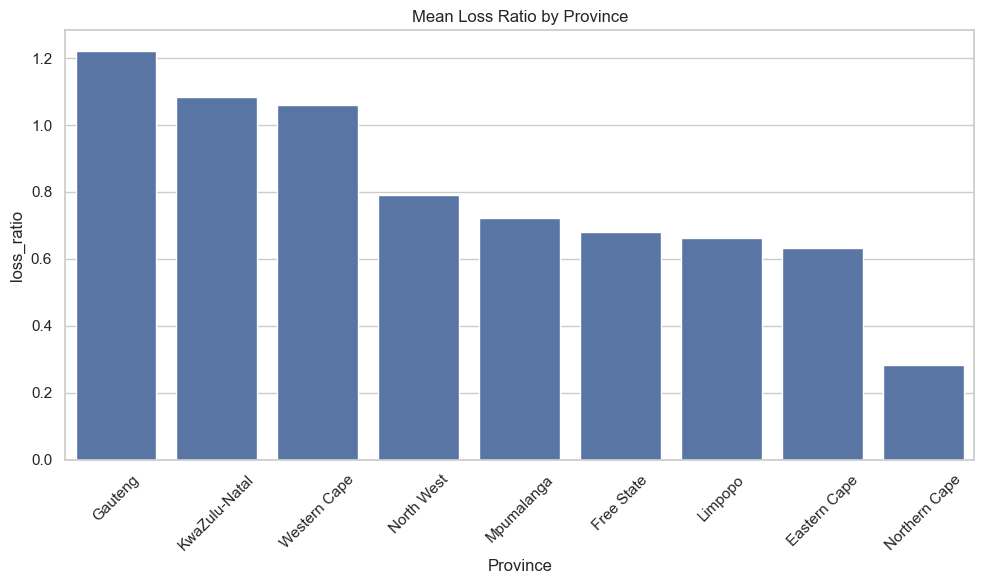

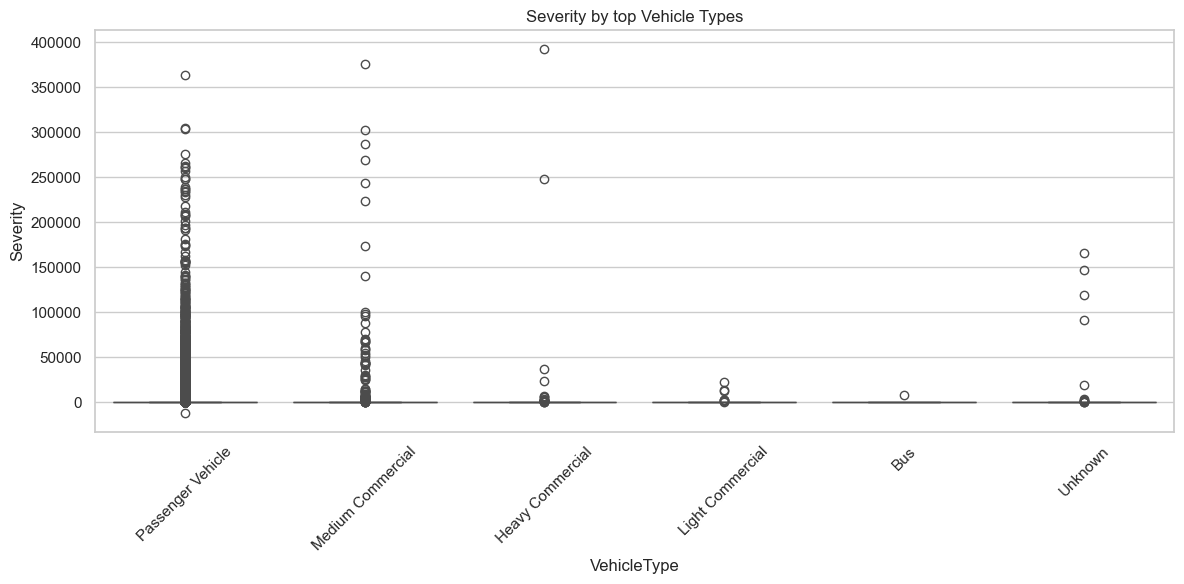

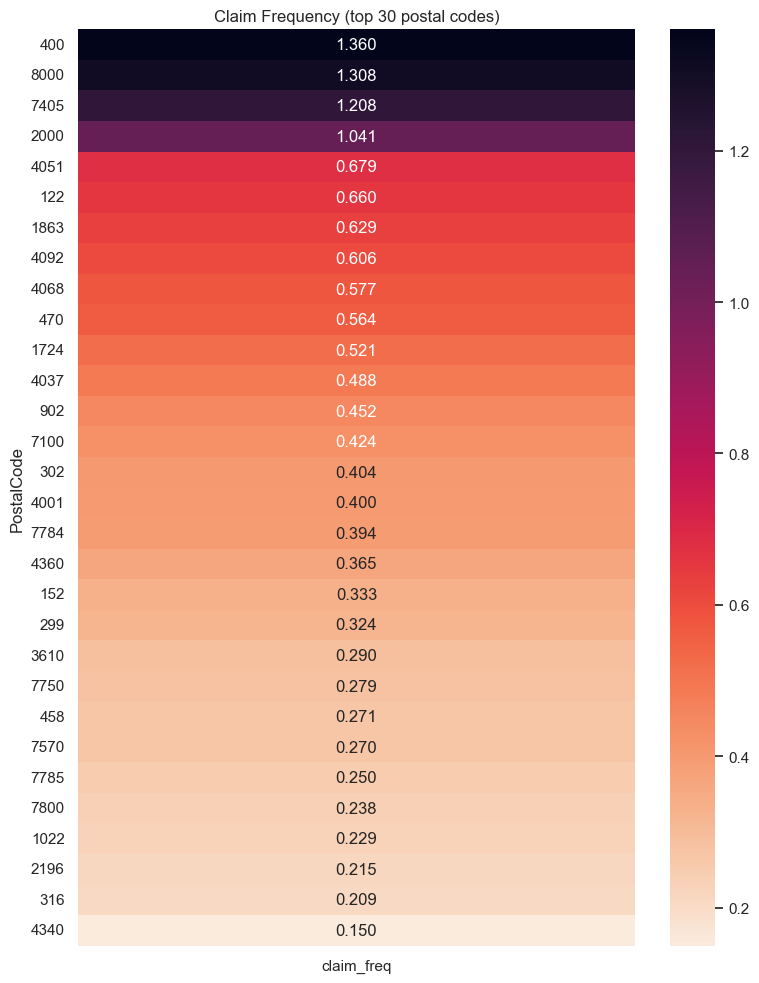

Visuals saved to c:\Users\a_kas\acis-insurance-risk-analytics\visuals


In [17]:
# Visualizations
# 1) Mean loss ratio by Province (bar)
if 'Province' in df.columns:
    prov = cohort_summary(df, 'Province').sort_values('loss_ratio', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Province', y='loss_ratio', data=prov)
    plt.xticks(rotation=45)
    plt.title('Mean Loss Ratio by Province')
    plt.tight_layout()
    plt.savefig(VISUALS_DIR / 'lossratio_by_province.png', dpi=150)
    plt.show()

# 2) Severity by VehicleType (boxplot)
if 'VehicleType' in df.columns:
    plt.figure(figsize=(12,6))
    top_vt = df['VehicleType'].value_counts().head(12).index.tolist()
    sns.boxplot(x='VehicleType', y='Severity', data=df[df['VehicleType'].isin(top_vt)])
    plt.xticks(rotation=45)
    plt.title('Severity by top Vehicle Types')
    plt.tight_layout()
    plt.savefig(VISUALS_DIR / 'severity_by_vehicletype.png', dpi=150)
    plt.show()

# 3) Heatmap of claim frequency across top postal codes
if 'PostalCode' in df.columns:
    top_postals = df['PostalCode'].value_counts().head(30).index.tolist()
    df_top = df[df['PostalCode'].isin(top_postals)]
    freq = df_top.groupby('PostalCode').agg(policies=('PolicyID','nunique'), claims=('HasClaim','sum'))
    freq['claim_freq'] = freq['claims']/freq['policies']
    plt.figure(figsize=(8,10))
    sns.heatmap(freq.sort_values('claim_freq', ascending=False)[['claim_freq']], annot=True, fmt='.3f', cmap='rocket_r')
    plt.title('Claim Frequency (top 30 postal codes)')
    plt.tight_layout()
    plt.savefig(VISUALS_DIR / 'postal_claimfreq_top30_heatmap.png', dpi=150)
    plt.show()

print('Visuals saved to', VISUALS_DIR)


In [18]:
# Save concise results summary to reports/
summary = {
    'total_policies': int(total_policies),
    'policies_with_claims': int(total_claims),
    'overall_loss_ratio': float(overall_loss_ratio) if not np.isnan(overall_loss_ratio) else None,
    'province_freq_p': province_result['p'] if province_result else None,
    'top30_postal_freq_p': postal_result['p'] if ('postal_result' in globals() and postal_result) else None,
    'province_severity_p': prov_sev['p'] if prov_sev else None,
    'top30_postal_margin_p': postal_margin['p'] if ('postal_margin' in globals() and postal_margin) else None,
    'gender_freq_p': gender_results.get('freq', {}).get('p') if 'gender_results' in globals() else None,
    'gender_severity_p': gender_results.get('severity', {}).get('p') if 'gender_results' in globals() else None,
    'gender_margin_p': gender_results.get('margin', {}).get('p') if 'gender_results' in globals() else None
}
out = REPORTS_DIR / 'task3_stats_summary.json'
with open(out, 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved summary JSON to', out)

# Also save CSV version
pd.Series(summary).to_csv(REPORTS_DIR / 'task3_stats_summary.csv')
print('Saved summary CSV to', REPORTS_DIR / 'task3_stats_summary.csv')


Saved summary JSON to c:\Users\a_kas\acis-insurance-risk-analytics\reports\task3_stats_summary.json
Saved summary CSV to c:\Users\a_kas\acis-insurance-risk-analytics\reports\task3_stats_summary.csv
